# SVGA

# Pseudo Code

1. Find the nearest polygon that intersect with direct path.
  - find whether the path crosses each polygon
  - if it crosses polygons find distance between path
  - find the index of polygon with lowest distance

2. Find the two outermost points on the polygon, from the perspective of the line.
  - find the visibile points of the polygon from point
    - take start as a point and each vertex of the polygon as a line segment
    - check if intersection of polygon and the line segment is a point, if yes, it is a visible point
  - find points that have max dist from the intersecting line segment on both sides.

3. Form a path taking the start point as start point, and the nearest outermost point (see code for logic, its a little complex) as end point, repeat the steps 1 and 2 recursively, taking path = (previous end point, next nearest outermost point) until there is no polygon between start and end points.

4. Do this until there is no polygon between the n-1 th and the end point of the path.

## Note: The above method is a custom modified SVGA implementation that does not require constructing the SVG graph (the next code section has the proper SVGA implementation)

In [7]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

from shapely.geometry import Point, LineString, MultiPoint, LinearRing
from shapely.geometry.polygon import Polygon

visited_points={}

def make_path(start, end):
  path = LineString([start, end])
  return path

def nearest_polygon(start,end,polys):
  """
  Finds the index of the nearest polygon to the start points
  inputs: start point (start), polygon array (polys)
  output: index of nearest polygon in the array
  """
  nearest_dist = float('inf')
  nearest_idx = 0
  path = make_path(start,end)

  for idx, poly in enumerate(polys):
    if path.crosses(poly) and start.distance(poly)<nearest_dist:
      nearest_dist = start.distance(poly)
      nearest_idx = idx
  return nearest_idx

def visible_points(start, poly):
  """
  Finds the vertices of a polygon that are visible from the start point
  inputs: start point (start), polygon
  """
  vis_points = []
  for coord in list(poly.exterior.coords[:-1]):
    line = LineString([start, Point(coord[0],coord[1])])

    # vertex is visible if the line it forms with start point intersects the polygon at a point,
    # not a line or any other shape
    if line.intersection(poly).geom_type == 'Point':
      vis_points.append(coord)
  return vis_points

def adjacent_points(poly, vertex):
  """
  input: polygon, a vertex of the polygon
  output: adjacent points of a vertex in a polygon
  """
  coords = list(poly.exterior.coords)[:-1]
  idx = coords.index(vertex)
  return [coords[idx-1],coords[(idx+1)%len(coords)]]

def outermost_points(polys, path):
  """
  Finds the outermost points of the nearest polygon that falls in line of sight of path
  inputs: polygon array (polys), path
  output: two outermost points on nearest polygon
  """
  start = Point(path.bounds[0], path.bounds[1])
  end = Point(path.bounds[-2], path.bounds[-1])

  nearest_idx = nearest_polygon(start,end,polys)
  
  #find visible vertices of the nearest polygon
  vis_points = visible_points(start, polys[nearest_idx])
  
  if len(vis_points)<2:
    return adjacent_points(polys[nearest_idx],(start.x,start.y))
    
  #find vertices on each side of the line
  sides=[[],[]]
  for point in vis_points:
    if LinearRing([start.coords[0], end.coords[0], point]).is_ccw:
      sides[0].append(point)
    else:
      sides[1].append(point)
  
  #find extreme points on each side
  outermost_points=[]
  for side in sides:
    farthest_dist_side = 0
    farthest_idx_side = 0
    if len(side)!=0:
      for idx, point in enumerate(side):
        if Point(point).distance(path)>farthest_dist_side:
          farthest_dist_side = Point(point).distance(path)
          farthest_idx_side = idx
      outermost_points.append(side[farthest_idx_side])
    else:
      outermost_points.append((None, None)) #i.e. whole side is invisible

  #find extreme points on each side
  return outermost_points

def outermost_points_alt(polys, start, end):
  """
  Finds the outermost points of the nearest polygon that falls in line of sight of path
  inputs: polygon array (polys), path
  output: two outermost points on nearest polygon
  """

  nearest_idx = nearest_polygon(start,end,polys)
  
  #find visible vertices of the nearest polygon
  vis_points = visible_points(start, polys[nearest_idx])
  
  if len(vis_points)<2:
    return adjacent_points(polys[nearest_idx],(start.x,start.y))
    
  #find vertices on each side of the line
  sides=[[],[]]
  for point in vis_points:
    if LinearRing([start.coords[0], end.coords[0], point]).is_ccw:
      sides[0].append(point)
    else:
      sides[1].append(point)
  
  #find extreme points on each side
  outermost_points=[]
  for side in sides:
    farthest_dist_side = 0
    farthest_idx_side = 0
    if len(side)!=0:
      for idx, point in enumerate(side):
        if Point(point).distance(path)>farthest_dist_side:
          farthest_dist_side = Point(point).distance(path)
          farthest_idx_side = idx
      outermost_points.append(side[farthest_idx_side])
    else:
      outermost_points.append((None, None)) #i.e. whole side is invisible

  #find extreme points on each side
  return outermost_points

def find_paths(start, end, polys):
  """
  inputs: start point, end point, map - polygons
  output: a list of paths
  """
  tempo_polys = sorted(polys,key=lambda x: x.distance(start), reverse=False)[:] # sorted list of polygons by distance from start point
  temp_start = start

  planned_path = []

  while True:
    temp_polys = tempo_polys # discard previous polygon
    temp_path = make_path(temp_start,end)

    #checks if any polygon crosses path, if not, loop can break as there is a direct path to the end
    crosses = False
    for poly in temp_polys:
      crosses = True if temp_path.crosses(poly) == True else crosses
  
    # for visualization/debug purposes
    # for poly in polys:
    #   plt.plot(*poly.exterior.xy, 'g')
    # plt.plot(*temp_path.xy, 'rx-')
    # plt.show()

    if crosses:
      outermost_pts = outermost_points(temp_polys,temp_path)

      #for visualization/debug purposes
      # plt.scatter([x[0] for x in outermost_pts], [x[1] for x in outermost_pts])
      
      # to prevent oscillation between same locally optimal points, keep track of visited points
      if str(Point(outermost_pts[0])) in visited_points: 
        temp_end = Point(outermost_pts[1])
      elif str(Point(outermost_pts[1])) in visited_points:
        temp_end = Point(outermost_pts[0])
      else:
        flag = end.distance(Point(outermost_pts[0])) < end.distance(Point(outermost_pts[1]))
        temp_end = Point(outermost_pts[0]) if flag else Point(outermost_pts[1])

      new_paths = find_paths(temp_start,temp_end,temp_polys)
      for path in new_paths:
        planned_path.append(path)
      
      visited_points[str(temp_start)] = True
      temp_start = temp_end
    else:
      new_path = make_path(temp_start,end)
      planned_path.append(new_path)

      return planned_path

## Constructing a SVG graph
1. Construct a graph for all possible feasible paths touching the outermost points of polygon - called Super Visble Graph (SVG)
2. Apply Djikstra's algothm to find the shortest path along the graph - gives result close enough to the optimal path

In [8]:
# makes a graph - from pythoncourse.eu
# making a graph data structure as a class

import matplotlib.pyplot as plt
%matplotlib inline

class Graph(object):

    def __init__(self, graph_dict=None):
        """ initializes a graph object 
        If no dictionary or None is given, 
        an empty dictionary will be used
        """
        if graph_dict == None:
            graph_dict = {}
        self.__graph_dict = graph_dict

    def vertices(self):
        """ returns the vertices of a graph """
        return list(self.__graph_dict.keys())

    def edges(self):
        """ returns the edges of a graph """
        return self.__generate_edges()
    
    def to(self, vertex):
        to_vertices = []
        if vertex in self.__graph_dict:
            to_vertices = self.__graph_dict[vertex]

        return to_vertices
    
    def dict(self):
        return self.__graph_dict

    def add_vertex(self, vertex):
        """ If the vertex "vertex" is not in 
        self.__graph_dict, a key "vertex" with an empty
        list as a value is added to the dictionary. 
        Otherwise nothing has to be done. 
        """
        if vertex not in self.__graph_dict:
            self.__graph_dict[vertex] = []

    def add_edge(self, edge):
        """ assumes that edge is of type set, tuple or list; 
        between two vertices can be multiple edges! 
        """
        (vertex1, vertex2) = tuple(edge)
        if vertex1 in self.__graph_dict:
            self.__graph_dict[vertex1].append(vertex2)
        else:
            self.__graph_dict[vertex1] = [vertex2]

    def __generate_edges(self):
        """ A static method generating the edges of the 
        graph "graph". Edges are represented as sets 
        with one (a loop back to the vertex) or two 
        vertices 
        """
        edges = []
        for vertex in self.__graph_dict:
            for neighbour in self.__graph_dict[vertex]:
                if {neighbour, vertex} not in edges:
                    edges.append({vertex, neighbour})
        return edges

    def plot(self):
        """
        plots the graph
        """
        edges = self.edges()
        vertices = self.vertices()
        for edge in edges:
            ed = list(edge)
            x_values = [ed[0][0], ed[1][0]]
            y_values = [ed[0][1], ed[1][1]]
            plt.plot(x_values,y_values,'rx-')

        plt.scatter([i[0] for i in vertices],[i[1] for i in vertices])

    def __str__(self):
        res = "vertices: "
        for k in self.__graph_dict:
            res += str(k) + " "

        res += "\nedges: "
        for edge in self.__generate_edges():
            res += str(edge) + " "

        return res


def make_graph(start, end, polys):
  """
  inputs: start point, end point, map - polygons
  output: a graph of all possible SVG paths - i.e. a SVG graph
  """
  visited_points={}
  graph = Graph()
  graph.add_vertex((start.x,start.y))
  graph.add_vertex((end.x,end.y))

  def recursion_depth(start, end, polys): #meme
    start = Point(start)
    end = Point(end)
    tempo_polys = sorted(polys,key=lambda x: x.distance(start), reverse=False)[:] # sorted list of polygons by distance from start point
    
    temp_polys = tempo_polys # discard previous polygon
    temp_path = make_path(start,end)

    #checks if any polygon crosses path, if not, loop can break as there is a direct path to the end
    crosses = False
    for poly in temp_polys:
      crosses = True if temp_path.crosses(poly) == True else crosses

    if crosses:
      outermost_pts = outermost_points_alt(temp_polys,start,end)

      if str(Point(outermost_pts[0])) in visited_points: 
        recursion_depth(start, outermost_pts[1], temp_polys)
        recursion_depth(outermost_pts[1], end, temp_polys)

      elif str(Point(outermost_pts[1])) in visited_points:
        recursion_depth(start, outermost_pts[0], temp_polys)
        recursion_depth(outermost_pts[0], end, temp_polys)

      else:
        for point in outermost_pts:
          recursion_depth(start, point, temp_polys)
          recursion_depth(point, end, temp_polys)

      visited_points[str(start)] = True

    else:
      visited_points[str(start)] = True
      graph.add_edge([(start.x,start.y), (end.x,end.y)])
      graph.add_vertex((start.x,start.y))
      graph.add_vertex((end.x,end.y))
      return

  recursion_depth(start,end,polys)
  return graph

## Setting up the polygons (that represent geo fences) and the start & end points

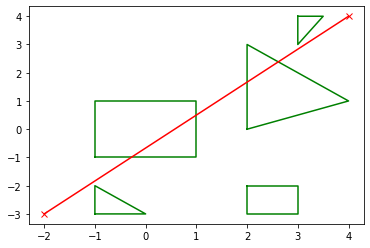

In [9]:
polys = np.array([Polygon([[-1,-1], [-1,1], [1,1], [1,-1]]),
                  Polygon([[-1,-3], [-1,-2], [0,-3]]),
                  Polygon([[2,0], [2,3], [4,1]]),
                  Polygon([[3,4], [3,3], [3.5,4]]),
                  Polygon([[2,-2],[2,-3], [3,-3], [3,-2]])])

start = Point(-2,-3)
end = Point(4,4)

for poly in polys:
  plt.plot(*poly.exterior.xy, 'g')

path = make_path(start, end)
plt.plot(*path.xy, 'rx-')

plt.show()

# The full final path using Cumulative SVG Algorithm

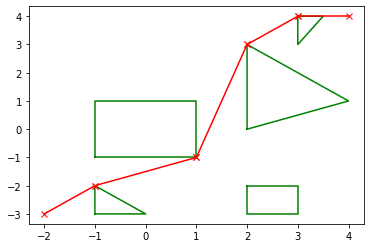

In [10]:
planned_path = find_paths(start, end, polys)
for poly in polys:
  plt.plot(*poly.exterior.xy, 'g')
for path in planned_path:
  plt.plot(*path.xy, 'rx-')
plt.show()

## Using SVG graph construction

In [11]:
graph = make_graph(start,end,polys)

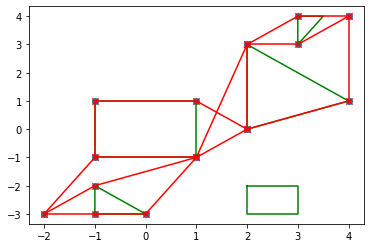

In [12]:
for poly in polys:
  plt.plot(*poly.exterior.xy, 'g')
graph.plot()

# Now apply djikstra's algorithm

In [13]:
import math

def length(fr, to):
    (x1, y1) = tuple(fr)
    (x2, y2) = tuple(to)
    return math.sqrt((x2-x1)**2 + (y2-y1)**2)

def dijkstra(graph, start, end):
  
    queue = []
    order = {}
    dist = {}
    dist[start] = 0

    for v in graph.vertices():
        if v != start:
            dist[v] = float('inf')
        queue.append(v)
        

    found = False
    while len(queue) > 0:
        min_v = queue[0]
        for q in queue:
            if dist[q] < dist[min_v]:
                min_v = q

        queue.remove(min_v)
        
        done = False
        for u in graph.to(min_v):
            alt = dist[min_v] + length(min_v, u)
            if alt < dist[u]:
                dist[u] = alt
                order[u] = min_v
                if u == end:
                    done = True
        
        if done:
            found = True
    
    if not found:
        print("No Path Found")
        return

    # Find the path from the order
    path = [end]
    curr = end
    while curr != start:
        fr = order[curr]
        path.append(fr)
        curr = fr
    
    return path[::-1]

[(-2.0, -3.0), (-1.0, -2.0), (1.0, -1.0), (2.0, 3.0), (3.0, 3.0), (4.0, 4.0)]


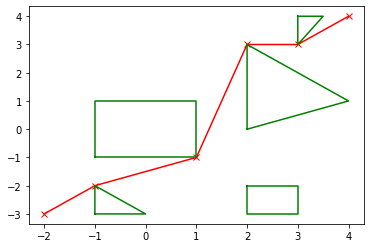

In [14]:
path = dijkstra(graph, (start.x, start.y), (end.x, end.y))
print(path)

for v in path:
  plt.plot(v[0], v[1], 'rx-')

plt.plot(*zip(*path), 'r')
for poly in polys:
  plt.plot(*poly.exterior.xy, 'g')
plt.show()